### Lucas Asset Pricing
- $z \sim N(0,\sigma)$ is shock process
- $y' = g(y,z) = \rho y+z$ is AR(1) endowment process
- $u(c) = c^{1-\gamma}/(1-\gamma)$ is utility function
- $f(y) = u'(y)p(y)$
- $f(y) = T(f)(y) = β E[f(y')+u(y')y']$ is Euler equation with $c=y$ (no trade in eqbm) and $s=1$ (full ownership)

In [1]:
import numpy as np
import plotly.io as pio
pio.renderers.default = "svg"
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')

In [64]:
def model(β = 0.95, ρ = 0.9, γ = 2.0, σ = 0.1, Ngrid = 100, tol = 1e-10, show_f = False, T = 200):
    
    def g(y,z):
        return np.exp(ρ*np.log(y)+z)

    def uprime(c):
        return c**(-γ)

    def p(y, F):
        return F / uprime(y)

    σy = σ/np.sqrt(1-ρ**2)
    Y = np.linspace(np.exp(-4*σy),np.exp(+4*σy),Ngrid)
    F_old = uprime(Y)
    F_new = uprime(Y)
    shocks = np.random.normal(0,σ,100)
    
    # VFI
    error = 1
    while error > tol:
        for y_i,y in enumerate(Y):
            yp = g(y,shocks) # generate many y'
            yp_i = np.abs(Y.reshape(-1,1) - yp).argmin(axis=0) # find idx of y'
            F_new[y_i] = β*np.mean(F_old[yp_i]+uprime(yp)*yp) # update with Expectation
        error = np.max(np.abs(F_new - F_old))
        F_old = np.copy(F_new)
        
    if show_f == True: 
        fig = px.line(x=Y, y=F_new, labels={'x':'y', 'y':'f(y)'}, title = 'Fixed Point Function')
        fig.show()   

    px.line(y=p(Y, F_new),x=Y, labels={'x':'y', 'y':'P(y)'}, title = 'Asset Price').show()
    
    # Simulate
    ySim = np.ones(T)
    ySim[0] = np.mean(Y)
    P = p(Y, F_new)
    pSim = np.zeros(T)
    zSim = np.random.normal(0,σ,T)
    for t in range(1, T):
        ySim[t] = np.exp(ρ*np.log(ySim[t-1])+zSim[t])
        y_i = np.abs(Y.reshape(-1,1) - ySim[t]).argmin(axis=0)
        pSim[t] = P[y_i]

    from plotly.subplots import make_subplots
    subfig = make_subplots(specs=[[{"secondary_y": True}]])
    fig1 = px.line(pSim, labels={'x':'time', 'y':'p(t)'}, title = 'P[t]')
    fig2 = px.line(ySim, labels={'x':'time', 'y':'p(t)'}, title = 'P[t]')
    fig1.update_traces(yaxis="y1",showlegend=True,name='Asset Price', line_color='red')
    fig2.update_traces(yaxis="y2",showlegend=True,name='Income')
    subfig.add_traces(fig1.data + fig2.data).show()
    
    return Y, F_new, p, β, ρ, γ, σ, Ngrid, tol, T


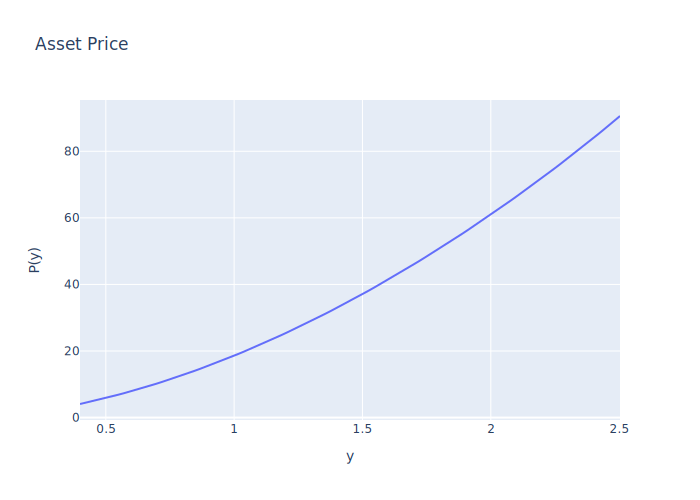

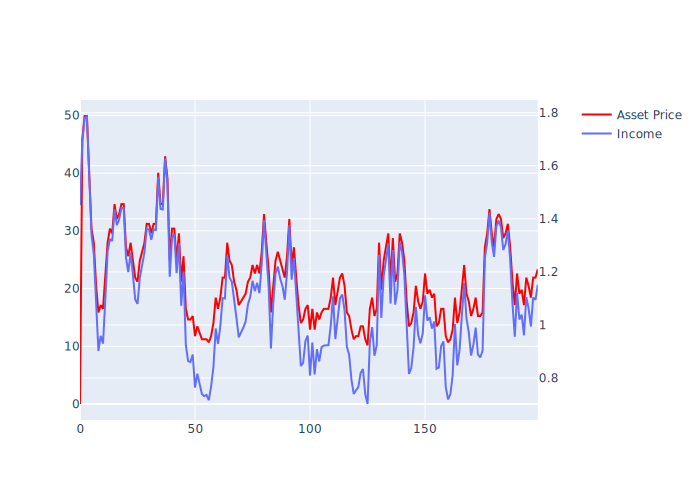

In [65]:
model();

In [ ]:
# Patient agents will value asset more as NPV of asset has risen. 
model(β = 0.99);

In [ ]:
# Agents will value asset lesser if income shocks are not persistent 
model(ρ = 0);

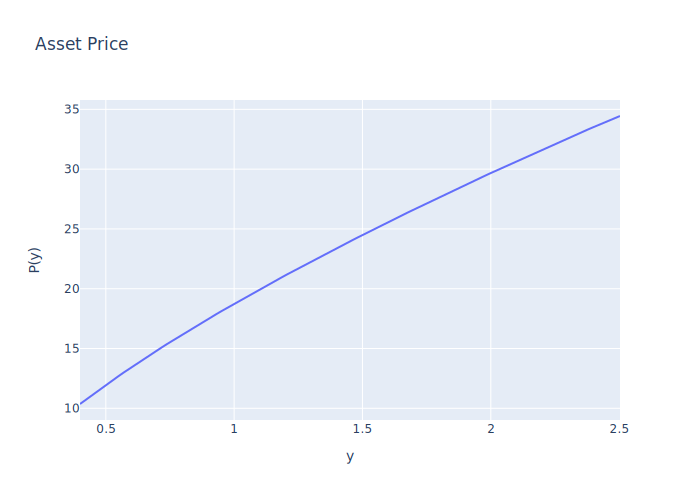

In [6]:
# Lower risk aversion 
model(γ = 0.5);

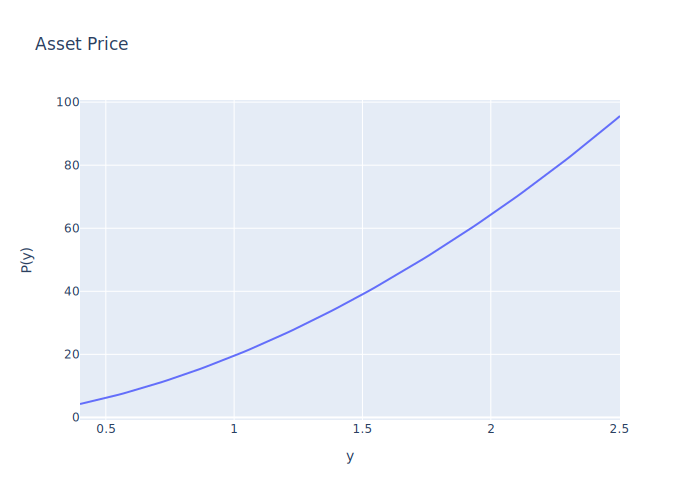

In [8]:
Y, F_new, p, β, ρ, γ, σ, Ngrid, tol = model()

In [58]:
# Simulations
#Y, F_new, p, β, ρ, γ, σ, Ngrid, tol = model()
T = 200
ySim = np.ones(T)*1.5
ySim[0] = 1.5
P = p(Y, F_new)
pSim = np.zeros(T)
zSim = np.random.normal(0,σ,T)
for t in range(1, T):
    ySim[t] = np.exp(ρ*np.log(ySim[t-1])+zSim[t])
    y_i = np.abs(Y.reshape(-1,1) - ySim[t]).argmin(axis=0)
    pSim[t] = P[y_i]


from plotly.subplots import make_subplots
subfig = make_subplots(specs=[[{"secondary_y": True}]])
fig1 = px.line(pSim, labels={'x':'time', 'y':'p(t)'}, title = 'P[t]')
fig2 = px.line(ySim, labels={'x':'time', 'y':'p(t)'}, title = 'P[t]')
fig1.update_traces(yaxis="y1",showlegend=True,name='Asset Price', line_color='red')
fig2.update_traces(yaxis="y2",showlegend=True,name='Income')
subfig.add_traces(fig1.data + fig2.data)
subfig.show()
